In [1]:
import pandas
from shap.plots import beeswarm, bar, scatter 
from shap import Explanation
import matplotlib.pyplot as pl
import numpy
import math

In [2]:
bs = 64
num_epochs = 100
prefix = 'sans_block'
T = 3

shap_df = pandas.read_csv(f'../../../results/{prefix}_bs={bs}_maxep={num_epochs}_rt/T={T}-shap_gradient_probedsideandrewardcontingencyconditioned.csv')

In [3]:
def is_accurate(r, t):
    if r[f'is_correct{t}'] == 1:
        return 1
    if r[f'is_wrong{t}'] == 1:
        return 0
    return numpy.nan


def title_fn(probed_side, reward_contingency):
    if probed_side == 0:
        if reward_contingency == 0:
            return 'FX Probed - Reward @ VR<FX @ T'
        else:
            return 'FX Probed - Reward @ VR>FX @ T'
    else:
        if reward_contingency == 0:
            return 'VR Probed - Reward @ VR<FX @ T'
        else:
            return 'VR Probed - Reward @ VR>FX @ T'


# Overall SHAP Plot

In [4]:
for time in range(T + 1):
    shap_df[f'is_accurate{time}'] = shap_df.apply(lambda row: is_accurate(row, time), axis=1)
    shap_df[f'is_accurate{time}_shap'] = shap_df[f'is_correct{time}_shap'] + shap_df[f'is_wrong{time}_shap']


In [5]:
explanations = {}

columns = []
shap_columns = []
feature_names = []

for var, var_name, sep in [
    ('reward_vr_fx', 'Reward@VR>FX', '@'), 
    ('change_fx', 'Change@FX', '@'), 
    ('change_vr', 'Change@VR', '@'),
    ('side_probed', 'ProbedSide', '@'), 
    ('is_accurate', 'IsAccurate', '@'), 
    ('stimulus_time', 'StimulusDuration', '@'), 
    ('accrued_score', 'AccruedScore', 'Until'),
]:
    for time in range(T + 1):
        
        if time < T and var in ['stimulus_time', 'accrued_score']:
            continue
        
        col_name = f"{var}{time}"
        columns.append(col_name)
        shap_columns.append(col_name + '_shap')
        
        if T-time == 0:
            feature_names.append(f'{var_name} {sep} T   ')
        else:
            feature_names.append(f'{var_name} {sep} T-{T-time}')

columns.extend([
#     'sub_emb', 
#     'block_emb'
])
feature_names.extend([
#     'Subject', 
#     'Block'
])
shap_columns.extend([
#     'sub_shap', 
#     'block_shap'
])

print(shap_df[shap_columns].min().min())
print(shap_df[shap_columns].max().max())

for probed_side in [0, 1]:
    for reward_contingency in [0, 1]:
        
        section_df = shap_df[
            (shap_df[f'side_probed{T}'] == probed_side) & 
            (shap_df[f'reward_vr_fx{T}'] == reward_contingency)
        ]

        _explanation = Explanation(values=section_df[shap_columns].values,
                                  feature_names=feature_names,
                                  data=section_df[columns].values)
        key = f'{probed_side}_{reward_contingency}'
        explanations[key] = _explanation


-0.5770312229726114
0.5294208128312312


All-NaN slice encountered


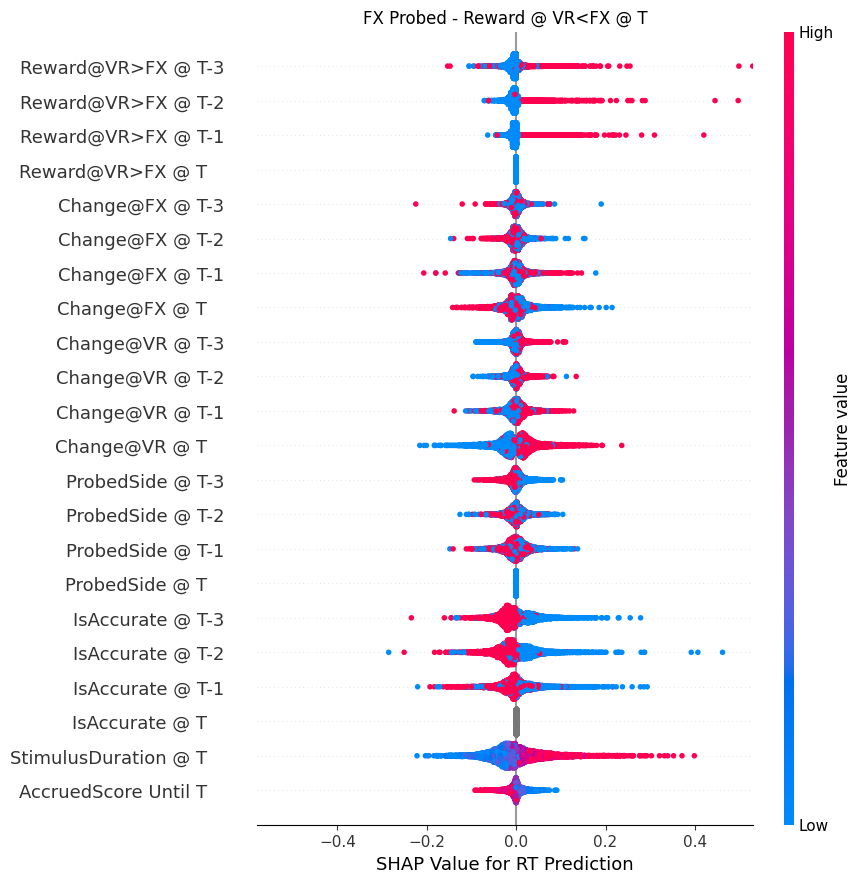

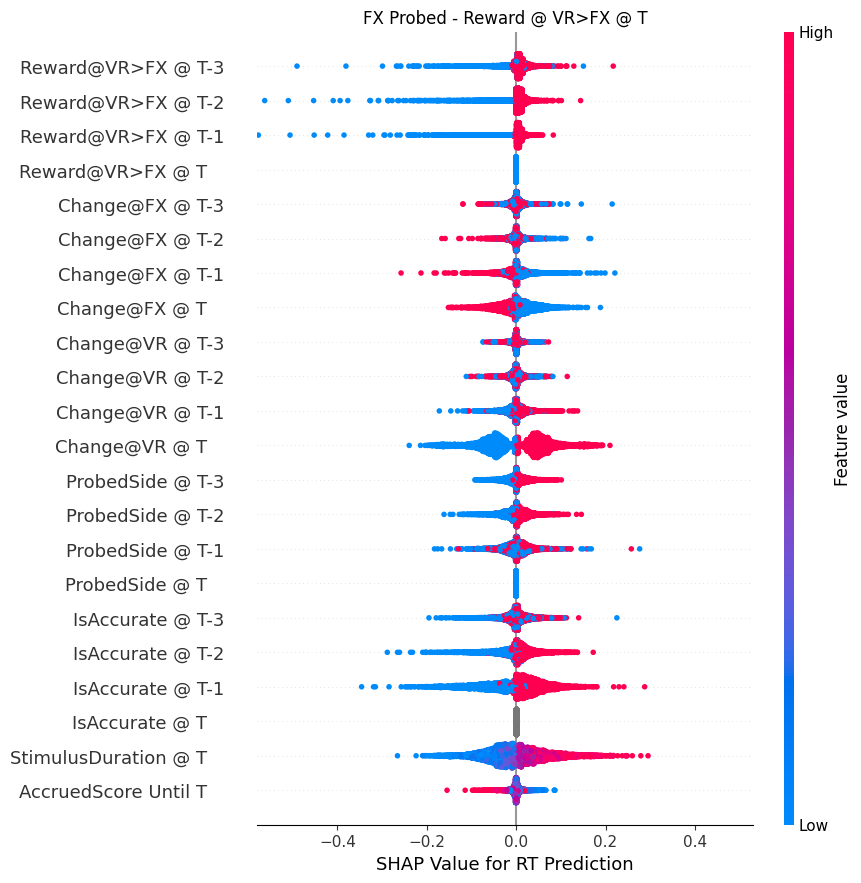

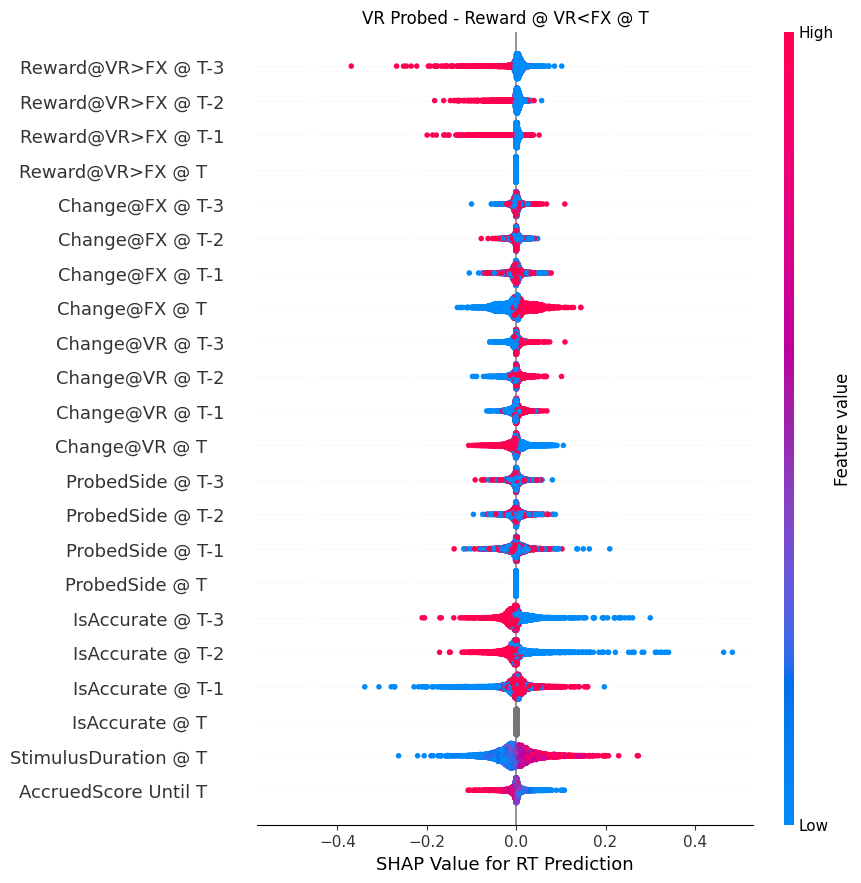

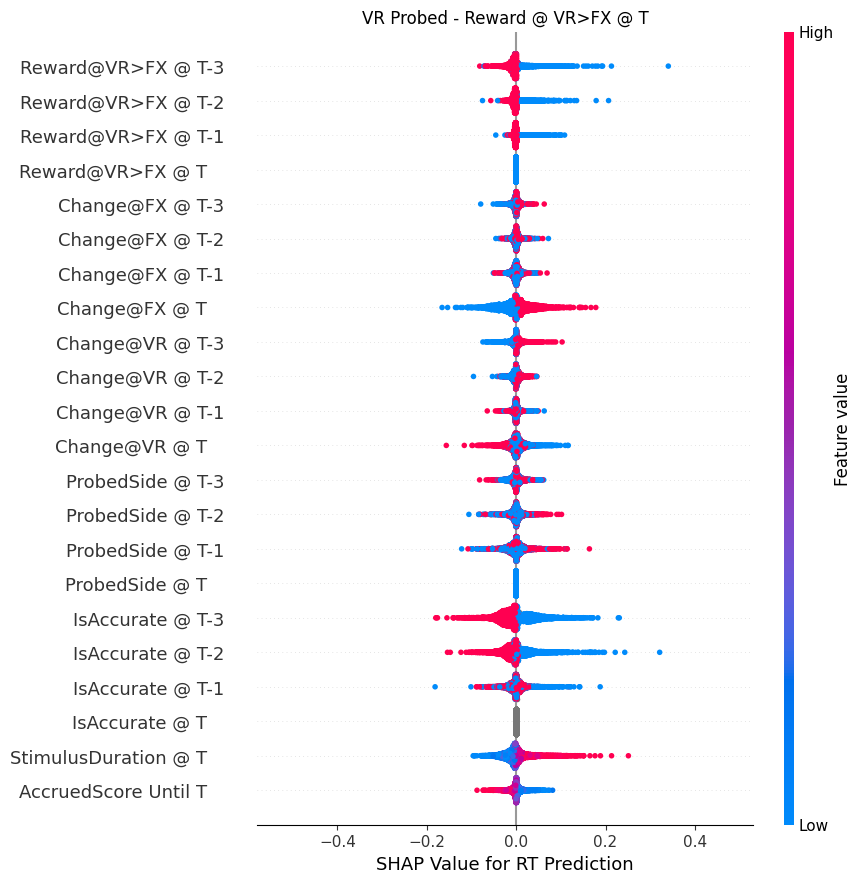

In [6]:
for probed_side in [0, 1]:
    for reward_contingency in [0, 1]:
        key = f'{probed_side}_{reward_contingency}'
        numpy.random.seed(0)
        beeswarm(explanations[key], show=False, color_bar=True,
                 order=list(range(len(explanations[key].feature_names))),
                 max_display=len(feature_names))
        pl.xlim([-0.58, 0.53])
        pl.xlabel("SHAP Value for RT Prediction")
        pl.title(f"{title_fn(probed_side, reward_contingency)}")
        pl.show()